In [1]:
import numpy as np
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import numba as nb
import sys
import os


sys.path.insert(0, os.path.realpath('./transport/'))

from transport import tallies
from transport import material_definitions
from transport import functions_for_transport
from transport import neutron


In [2]:
%matplotlib widget

In [165]:
def object_transport_function(neutron, material_definition, tallies, rng):

    # set x0 as xnew from previous transport
    neutron.x0 = neutron.x_new

    # get cross sections, don't need to search for material because its all one material
    Sig_t, Sig_g, Sig_s, Sig_f = material_definition.get_macro_cross_sections()

    # transport and tally
    tau = -np.log(1-rng.uniform(0,1))/Sig_t
    neutron.x_new = neutron.x0 + (tau*neutron.mu)
    # tallies = tallies.add_tallies(neutron) 


    ### if we hit the system boundary,
    if (neutron.x_new < tallies.vXbins[0]) or (neutron.x_new > tallies.vXbins[-1]):
        neutron.rxn = 0
        # neutron_object.x_new = tallies.bin_bounds(1) ; % redefines x_new as boundary
        # neutron_object.mu = - neutron_object.mu ;         % redefines mu as negative mu
        # [tallies, neutron] = obj_transport_function(neutron_object, tallies, Ndens_fuel, Ndens_mod) ;
        return neutron
    

    ### sample reaction and do something
    reaction = rng.uniform(low=0.0, high=Sig_t)

    if reaction <= Sig_g:
        # capture reaction - kill neutron object
        neutron.rxn = 0 
        return neutron
        
    elif reaction <= Sig_g + Sig_f:
        # kill old neutron object and create new fission neutron objects at x_new
        neutron.rxn = 1
        # make nubar more robust here
        return neutron
        
    else:
        # scattering reaction, transport same neutron object, location was updated    
        # update energy with scattering         !! could do this better !!
        neutron.rxn = 1
        neutron.mu = (2*rng.uniform(0,1))-1 
        neutron = object_transport_function(neutron, material_definition, tallies, rng)
        
    
    return neutron


def tally_born_vec(born_vec, tally, xborn):
    iborn = np.searchsorted(tally.vXbins, xborn)-1
    born_vec[iborn] += 1
    return

def tally_FM(FM1, FM2, rxn_loc, nu, tally):
    iborn = np.searchsorted(tally.vXbins, rxn_loc[2])-1
    ifis = np.searchsorted(tally.vXbins, rxn_loc[1])-1
    FM1[ifis, iborn] += nu
    FM2[ifis, iborn] += nu**2
    return FM1, FM2

def get_new_wx_array(N, fission_locations, FM_m1, born_vec, tally, rng):

    x0_array = np.zeros(N)
    source_MC = np.zeros(len(tally.Xbins))
    for new_source_particle in range(N):
        random_index = rng.integers(0, len(fission_locations))
        source_particle_location = fission_locations[random_index]
        x0_array[new_source_particle] = source_particle_location
        bindex = np.searchsorted(tally.vXbins, source_particle_location)-1
        source_MC[bindex] += 1

    source_MC = source_MC/np.sum(source_MC)

    FM_norm = FM_m1/born_vec
    FM_norm[np.isnan(FM_norm)] = 0
    FM_norm[(FM_norm<0)] = 0
    
    eigval, evec = np.linalg.eig(FM_norm)
    imaxeig = np.argwhere(eigval.real==max(eigval.real))[0]
    real_dominant_eigenvector = evec.real[:,imaxeig]
    source_FM = abs(real_dominant_eigenvector/np.linalg.norm(real_dominant_eigenvector)) # np.sum(real_dominant_eigenvector)
    source_FM[(source_FM<0)] = 0

    fmweight = source_FM.flatten()/source_MC
    # fmweight = 1/fmweight
    fmweight[np.isnan(fmweight)] = 0
    
    w_array_new = fmweight[np.searchsorted(tally.vXbins, x0_array)-1]

    return x0_array, w_array_new, source_MC, source_FM, source_FM.flatten()


In [170]:
N = int(1e3)
skipgen = 100
gen = 100

Xmin = 0
Xmax = 60
iX = 60
print(f'Particle Histories: {N}')
print(f'Spatial Bins: {iX}')

nuSig_f = 0.30713574
nubar = 2.89
Sig_s = 0.7
Sig_t = 1
Sig_f = nuSig_f/nubar
Sig_g = Sig_t-Sig_s-Sig_f

mat = material_definitions.material_MG(nubar, Sig_f, Sig_g, Sig_s)
rng = np.random.default_rng()
tally = tallies.tallies(Xmin=Xmin, Xmax=Xmax, iXbins=iX)

Particle Histories: 10000
Spatial Bins: 60


In [171]:
def get_neutron_array(x_array, w_array):
    neutron_array = []
    mu0 = (2*rng.uniform(0,1,size=len(x_array)))-1
    for iN in range(N):
        neutron_array.append(neutron.Neutron(x_array[iN], mu0[iN], w_array[iN]))
    return neutron_array

# init 
x0_array = rng.uniform(Xmin,Xmax,size=N)
# x0_array = np.ones(N)*30
w_array = np.ones(N)
neutron_array = get_neutron_array(x0_array,w_array)

FM_m1 = np.zeros((iX,iX))
FM_m2 = np.zeros((iX,iX))
born_vec = np.zeros(iX)


# for plotting
fmvals = np.zeros((skipgen-2, 6))
SMC = np.zeros((skipgen,iX))
SFM = np.zeros((skipgen,iX))
S = []
w3030_save = []
n3030 =  np.zeros(skipgen)
neutrons = 0
var = 0
k_m1 = []; k_m2 = []

# loop over skipgens
for isg in range(skipgen):

    # reset variables including tallies
    fission_locations = []
    # my_tallies = tallies(Xmin=Xmin, Xmax=Xmax, iXbins=iX)


    for iN in range(N):
        neutron_array[iN] = object_transport_function(neutron_array[iN], mat, tally, rng)
        
    # now look at capture vs fission (scattered neutrons continue to transport until cap/fis
    rxn_loc = np.array([[n.rxn for n in neutron_array],[n.x_new for n in neutron_array],[n.xborn for n in neutron_array],[n.w for n in neutron_array]])
    # append fission locations
    for iN in range(N):
        tally_born_vec(born_vec, tally, rxn_loc[2, iN])
        if rxn_loc[0,iN] == 0:
            pass
        elif rxn_loc[0,iN] == 1:
            nu = np.floor(mat.nubar*rxn_loc[3,iN] + rng.uniform(0,1))
            # if active generatiosn, tally nu and sample normally
            if isg > 25:
                nu = np.floor(mat.nubar + rng.uniform(0,1))
                neutrons += nu
                var += nu**2
            fission_locations.extend([rxn_loc[1,iN]]*int(nu))
            FM_m1, FM_m2 = tally_FM(FM_m1, FM_m2, rxn_loc[:,iN], nu, tally)

    # store values
    if isg > 1:
        FM_m1_norm = FM_m1/born_vec
        FM_m2_norm = FM_m2/born_vec
        FM_var = born_vec/(born_vec-1) * (FM_m2_norm - FM_m1_norm**2)
        FM_std = np.sqrt(FM_var)/np.sqrt(born_vec)
        fmvals[isg-2,:] = np.array([FM_m1_norm[0,0],FM_std[0,0], FM_m1_norm[9,9],FM_std[9,9], FM_m1_norm[29,29],FM_std[29,29]])

    # redefines fission neutron distribution
    # need to pass weighted nu to get new x0 array!!!!!!!!
    x0_array, w_array, source_MC, source_FM, w3030 = get_new_wx_array(N, fission_locations, FM_m1, born_vec, tally, rng)
    neutron_array = get_neutron_array(x0_array, w_array)
    w3030_save.append(w3030)
    S.append(x0_array)

    # store source
    SMC[isg, :] = source_MC.flatten()
    SFM[isg, :] = source_FM.flatten()

    # Active gens
    if isg > 25:
        gen = isg-25
        kn = neutrons/(N*gen)
        kn_var = (N*gen/((N*gen)-1)) * ( (var/(N*gen)) - (kn**2) ) 
        kn_std = (1/np.sqrt(N*gen)) * np.sqrt(kn_var)

print(kn)
print(kn_std)

/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_24939/3328269472.py:84: RuntimeWarning: divide by zero encountered in divide
  fmweight = source_FM.flatten()/source_MC


1.017495945945946
0.0016188672663154542


In [159]:
kn_std/(1/np.sqrt(N*gen))

0.0002340634315054914

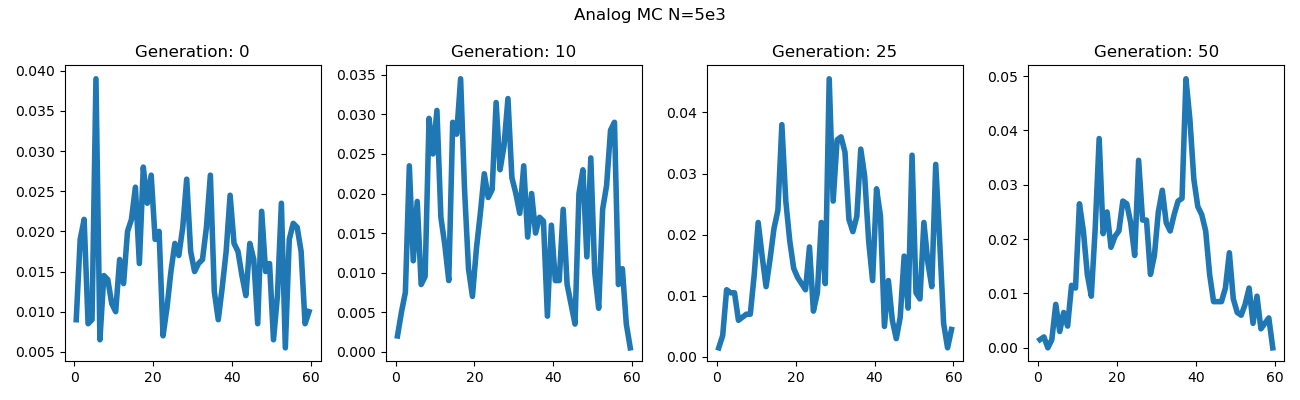

In [144]:
# figure()
# # plot(range(skipgen), w3030_save)
# bins = hist(S[0], bins=60)
# bins = hist(S[10], bins=60)
# bins = hist(S[25], bins=60)
# bins = hist(S[49], bins=60)
# title('FM Acceleration N=1e4')

fig, axes = subplots(1,4, figsize=(13,4))
suptitle('Analog MC N=5e3')
# suptitle('FM Acceleration N=1e3')

axes[0].plot(tally.Xbins, SMC[0, :], lw=4)
axes[0].set_title('Generation: 0')
axes[1].plot(tally.Xbins, SMC[10, :], lw=4)#, alpha=0.8)
axes[1].set_title('Generation: 10')
axes[2].plot(tally.Xbins, SMC[25, :], lw=4)#, alpha=0.6)
axes[2].set_title('Generation: 25')
axes[3].plot(tally.Xbins, SMC[50, :], lw=4)#, alpha=0.4)
axes[3].set_title('Generation: 50')

# for ax in axes:
#     ax.set_ylim([0,0.05])
fig.tight_layout()
# bins = hist(fission_locations, bins =100)
# plot(range(skipgen), n3030, 'o')

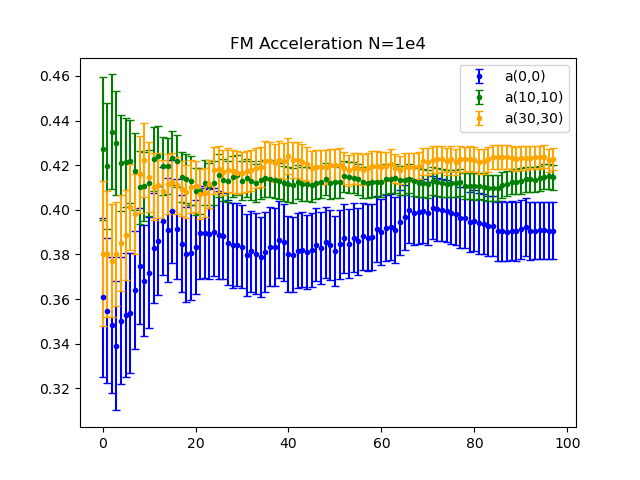

In [102]:
figure()
errorbar(range(skipgen-2), fmvals[:,0], yerr=fmvals[:,1], fmt='.', color='b', ecolor='b', capsize=3, label='a(0,0)')
errorbar(range(skipgen-2), fmvals[:,2], yerr=fmvals[:,3], fmt='.', color='g', ecolor='g', capsize=3, label='a(10,10)')
errorbar(range(skipgen-2), fmvals[:,4], yerr=fmvals[:,5], fmt='.', color='orange', ecolor='orange', capsize=3, label='a(30,30)')
title('FM Acceleration N=1e4')
legend()

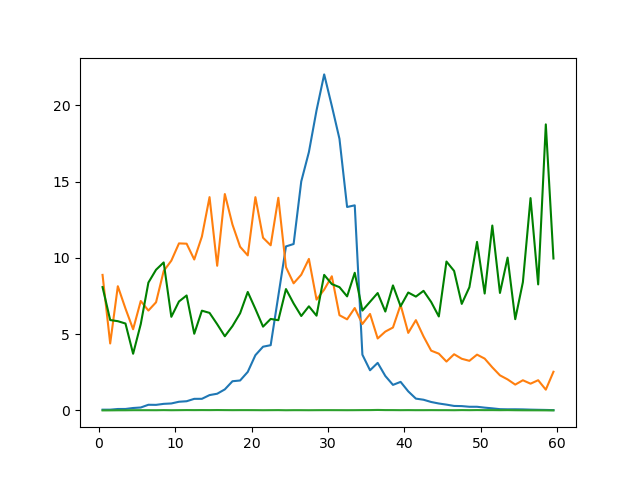

In [172]:
figure()
plot(tally.Xbins, SFM[0, :]/SMC[0, :])
plot(tally.Xbins, SFM[10, :]/SMC[10, :])
plot(tally.Xbins, SMC[25, :])
plot(tally.Xbins, SFM[49, :]/SMC[49, :], 'g')
# plot(tally.Xbins, SFM[99, :]/SMC[99, :], 'r')

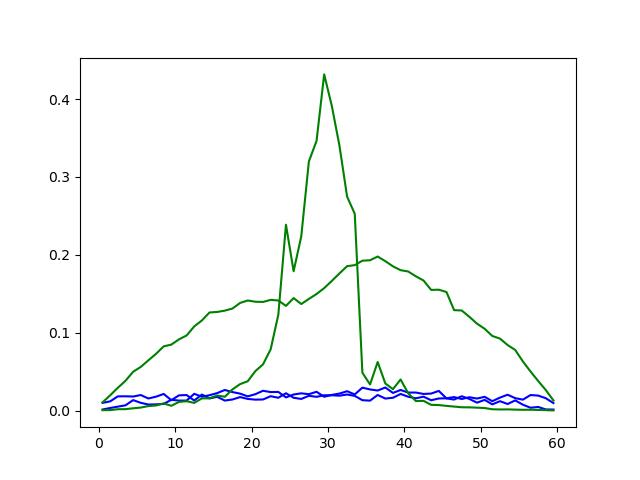

In [173]:
figure()
plot(tally.Xbins, SMC[0, :], 'b')
# plot(tally.Xbins, SMC[4, :], 'b')
plot(tally.Xbins, SMC[49, :], 'b')
# plot(tally.Xbins, SMC[80, :], 'b')

plot(tally.Xbins, SFM[0, :],'g')
# plot(tally.Xbins, SFM[4, :],'g')
plot(tally.Xbins, SFM[49, :], 'g')
# plot(tally.Xbins, SFM[80, :],'g')